# Rescaling Query Data to Match Reference Distribution

This notebook implements a method to rescale (subsample) query data from a BED file to match a reference distribution provided in a histogram file.

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
import argparse

## Helper Functions

The following functions handle reading, processing, and rescaling the data.

In [4]:
def read_reference_hist(hist_file):
    """Read the reference histogram file and return bin indices and frequencies."""
    bins = []
    frequencies = []
    
    with open(hist_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    bin_idx = int(parts[0])
                    frequency = float(parts[1])
                    bins.append(bin_idx)
                    frequencies.append(frequency)
                except ValueError:
                    continue
    
    return np.array(bins), np.array(frequencies)

In [5]:
def read_query_bed(bed_file):
    """Read the query bed file and extract values for binning."""
    values = []
    
    if bed_file.endswith('.gz'):
        opener = gzip.open
        mode = 'rt'  
    else:
        opener = open
        mode = 'r'
    
    with opener(bed_file, mode) as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) >= 3:  
                start = int(parts[1])
                end = int(parts[2])
                length = end - start
                values.append(length)
    
    return np.array(values)

In [6]:
def bin_values(values, min_bin=24, max_bin=700):
    """Bin the values and calculate normalized frequencies."""
    bins = range(min_bin, max_bin+1)
    hist, bin_edges = np.histogram(values, bins=bins)
    
    total = np.sum(hist)
    if total > 0:
        normalized_hist = hist / total
    else:
        normalized_hist = hist
    
    bin_indices = np.arange(min_bin, max_bin)
    
    return bin_indices, normalized_hist

In [7]:
def calculate_scaling_factors(ref_freq, query_freq):
    """Calculate scaling factors for each bin to match reference distribution."""
    scaling_factors = np.zeros_like(ref_freq)
    mask = query_freq > 0
    scaling_factors[mask] = ref_freq[mask] / query_freq[mask]
    
    window_size = 5
    scaling_factors = np.convolve(scaling_factors, np.ones(window_size)/window_size, mode='same')
    
    max_factor = 10.0
    scaling_factors = np.clip(scaling_factors, 0, max_factor)
    
    return scaling_factors

In [8]:
def subsample_query_data(query_values, bin_indices, scaling_factors, min_bin=24, max_bin=700, target_count=4295020):
    """Subsample the query data based on scaling factors with a target count."""
    subsampled_values = []
    original_entries = []
    
    bin_to_factor = {min_bin + i: factor for i, factor in enumerate(scaling_factors)}
    
    current_scaling_sum = 0
    bin_counts = {}
    
    for value in query_values:
        if min_bin <= value < max_bin:
            bin_idx = value - min_bin
            if bin_idx < len(scaling_factors):
                bin_counts[bin_idx] = bin_counts.get(bin_idx, 0) + 1
                
    for bin_idx, count in bin_counts.items():
        if bin_idx < len(scaling_factors):
            current_scaling_sum += count * scaling_factors[bin_idx]
    
    adjustment_factor = target_count / current_scaling_sum if current_scaling_sum > 0 else 1.0
    
    for i, value in enumerate(query_values):
        if min_bin <= value < max_bin:
            bin_idx = value - min_bin
            if bin_idx < len(scaling_factors):
                final_scaling = scaling_factors[bin_idx] * adjustment_factor
                if random.random() < final_scaling:
                    subsampled_values.append(value)
                    original_entries.append(i)
    
    return np.array(subsampled_values), np.array(original_entries)

In [9]:
def write_subsampled_bed(original_bed_file, original_indices, output_file):
    """Write a new BED file with subsampled entries based on original indices."""
    if original_bed_file.endswith('.gz'):
        opener = gzip.open
        read_mode = 'rt'  
    else:
        opener = open
        read_mode = 'r'
    
    indices_set = set(original_indices)
    
    if output_file.endswith('.gz'):
        write_opener = gzip.open
        write_mode = 'wt'  
    else:
        write_opener = open
        write_mode = 'w'
    
    with opener(original_bed_file, read_mode) as infile, write_opener(output_file, write_mode) as outfile:
        for i, line in enumerate(infile):
            if i in indices_set:
                outfile.write(line)

In [10]:
def plot_distributions(ref_bins, ref_freq, query_bins, query_freq, subsampled_bins, subsampled_freq, output_file):
    """Plot the reference, original query, and subsampled query distributions."""
    plt.figure(figsize=(12, 8))
    
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['xtick.major.width'] = 1.0
    plt.rcParams['ytick.major.width'] = 1.0
    
    query_count = len(query_values)
    plt.plot(query_bins, query_freq, '-', color='#8800cc', linewidth=1.5, label=f'Query (n = {query_count:,})')
    
    plt.plot(ref_bins, ref_freq, '-', color='#00aa00', linewidth=1.5, label='Reference')
    
    subsampled_count = len(subsampled_values)
    plt.plot(subsampled_bins, subsampled_freq, 'cyan', marker='*', 
             markersize=6, markevery=1, linewidth=1.0, label=f'Rep 0 (n = {subsampled_count:,})')
    
    plt.xlim(0, 700)
    plt.ylim(0, 0.025)
    
    plt.xticks(np.arange(0, 701, 100))
    plt.yticks(np.arange(0, 0.026, 0.005))
    
    plt.xlabel('Bin')
    plt.ylabel('Normalized Frequency')
    
    plt.legend(loc='upper right', frameon=False)
    
    plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    plt.show()

In [11]:
def parse_arguments():
    """Parse command line arguments."""
    parser = argparse.ArgumentParser(description='Rescale query data to match reference distribution.')
    parser.add_argument('--reference', '-r', default='reference.hist',
                        help='Path to reference histogram file (default: reference.hist)')
    parser.add_argument('--query', '-q', default='query.bed.gz',
                        help='Path to query BED file (default: query.bed.gz)')
    parser.add_argument('--output', '-o', default='subsampled_query.bed.gz',
                        help='Path to output subsampled BED file (default: subsampled_query.bed.gz)')
    parser.add_argument('--plot', '-p', default='distribution_comparison.png',
                        help='Path to output plot file (default: distribution_comparison.png)')
    parser.add_argument('--min-bin', type=int, default=24,
                        help='Minimum bin value (default: 24)')
    parser.add_argument('--max-bin', type=int, default=700,
                        help='Maximum bin value (default: 700)')
    return parser.parse_args()

## Main Execution

The following cells implement the main workflow for rescaling the data.

In [13]:
reference_hist_file = 'reference.hist'
query_bed_file = 'query.bed.gz'
output_bed_file = 'subsampled_query.bed.gz'
plot_file = 'distribution_comparison.png'
min_bin = 24
max_bin = 700

In [14]:
if not os.path.isabs(reference_hist_file):
    script_dir = os.getcwd()
    reference_hist_file = os.path.join(script_dir, reference_hist_file)

if not os.path.isabs(query_bed_file):
    script_dir = os.getcwd()
    query_bed_file = os.path.join(script_dir, query_bed_file)

if not os.path.isabs(output_bed_file):
    script_dir = os.getcwd()
    output_bed_file = os.path.join(script_dir, output_bed_file)

if not os.path.isabs(plot_file):
    script_dir = os.getcwd()
    plot_file = os.path.join(script_dir, plot_file)

In [15]:
print(f"Reading reference histogram from: {reference_hist_file}")
ref_bins, ref_freq = read_reference_hist(reference_hist_file)
print(f"Reference histogram has {len(ref_bins)} bins")

Reading reference histogram from: C:\Users\Vardh\OneDrive - iitr.ac.in\BEE\Rescaling\reference.hist
Reference histogram has 677 bins


In [16]:
print(f"Reading query data from: {query_bed_file}")
query_values = read_query_bed(query_bed_file)
print(f"Read {len(query_values)} entries from query file")

if len(query_values) == 0:
    print("Error: No data read from query file. Please check the file format.")
    raise ValueError("No data in query file")

Reading query data from: C:\Users\Vardh\OneDrive - iitr.ac.in\BEE\Rescaling\query.bed.gz
Read 13835737 entries from query file


In [17]:
query_bins, query_freq = bin_values(query_values, min_bin=min_bin, max_bin=max_bin)
print(f"Binned query data into {len(query_bins)} bins")

min_len = min(len(ref_freq), len(query_bins))
ref_freq_trimmed = ref_freq[:min_len]
query_freq_trimmed = query_freq[:min_len]
print(f"Using {min_len} bins for comparison")

Binned query data into 676 bins
Using 676 bins for comparison


In [18]:
scaling_factors = calculate_scaling_factors(ref_freq_trimmed, query_freq_trimmed)
print("Calculated scaling factors for subsampling")

Calculated scaling factors for subsampling


In [19]:
target_count = 4295020  
subsampled_values, original_indices = subsample_query_data(
    query_values, query_bins, scaling_factors, 
    min_bin=min_bin, max_bin=max_bin, 
    target_count=target_count
)
print(f"Subsampled to {len(subsampled_values)} entries ({len(subsampled_values)/len(query_values)*100:.2f}% of original)")

if len(subsampled_values) == 0:
    print("Warning: No entries were selected during subsampling. Check scaling factors.")
    raise ValueError("No entries selected during subsampling")

Subsampled to 4150324 entries (30.00% of original)


In [20]:
subsampled_bins, subsampled_freq = bin_values(subsampled_values, min_bin=min_bin, max_bin=max_bin)

In [21]:
write_subsampled_bed(query_bed_file, original_indices, output_bed_file)
print(f"Wrote subsampled data to: {output_bed_file}")

Wrote subsampled data to: C:\Users\Vardh\OneDrive - iitr.ac.in\BEE\Rescaling\subsampled_query.bed.gz


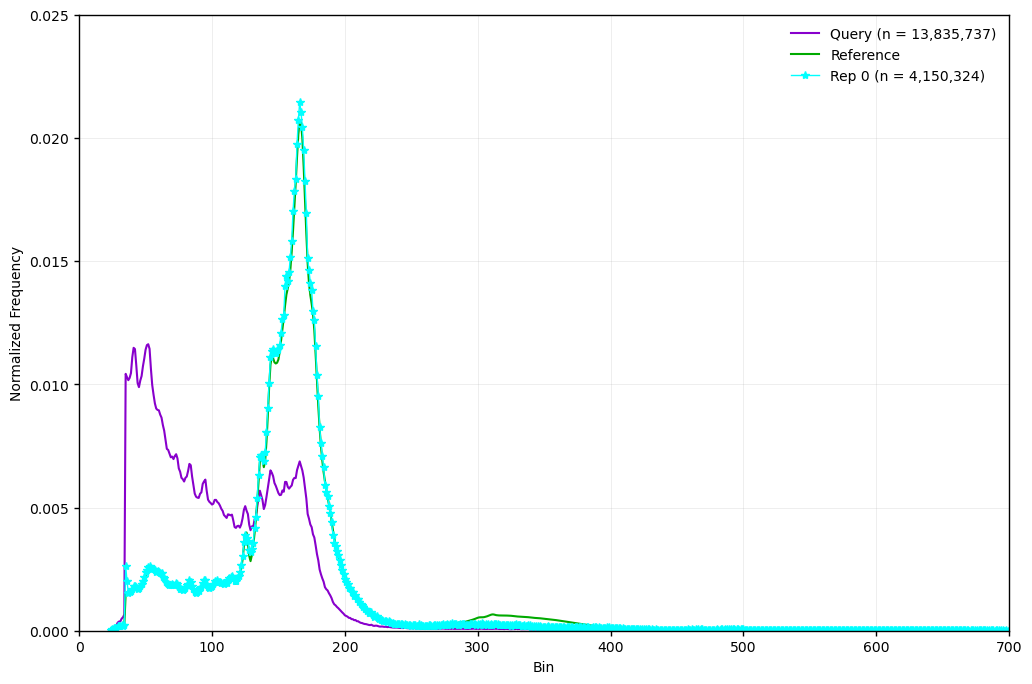

In [22]:
plot_distributions(ref_bins[:min_len], ref_freq_trimmed, 
                  query_bins[:min_len], query_freq_trimmed, 
                  subsampled_bins, subsampled_freq, 
                  plot_file)

In [23]:
print("\nRescaling completed successfully!")
print(f"Original query entries: {len(query_values)}")
print(f"Subsampled query entries: {len(subsampled_values)}")
print(f"Retention rate: {len(subsampled_values)/len(query_values)*100:.2f}%")


Rescaling completed successfully!
Original query entries: 13835737
Subsampled query entries: 4150324
Retention rate: 30.00%
